# DJIA Price Prediction LSTM with Wavelet Transforms and an Attention Mechanism

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pywt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from attention import Attention
from keras.optimizers import Adam
from keras import metrics
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)
from keras.utils.vis_utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt
from random import randint

### Load Dataset

In [2]:
df = pd.read_csv("./Datasets/DJIA.csv")

### Check Dataset is Clean

In [3]:
nulls = df.isnull().sum().sum() + df.isna().sum().sum()
boolSeries = df.duplicated().to_numpy()
if ((boolSeries.sum() == 0) and (nulls == 0)):
    print('Dataset is clean!')
else:
    print('Dataset is unclean!')

Dataset is clean!


### Split Dataset

In [4]:
splitDate = '2019-05-16'
trainingDataUnscaled = df[df['Date'] <= splitDate].copy()
trainingDataUnscaled.drop(['Date', 'Adj Close'], axis=1, inplace=True)

### Data Scaling

In [5]:
scaler = StandardScaler()
anotherScaler = MinMaxScaler()
trainingDataStandardised = scaler.fit_transform(trainingDataUnscaled)
trainingDataNormalised = anotherScaler.fit_transform(trainingDataStandardised)

### Wavelet Transform

In [6]:
# Three decomposition layers of Coiflet 3 wavelet transform
def WaveletTransform(data, levels, threshold=0.63, wavelet='coif3'):
    reconstructedData = pd.DataFrame()
    for i in range(data.shape[1]):
        threshold = threshold * np.nanmax(data[:,i])
        coefficients = pywt.wavedec(data[:,i], wavelet, mode='per', level=levels)
        coefficients[1:] = (pywt.threshold(i, value=threshold, mode='soft') for i in coefficients[1:])
        reconstructedColumn = pywt.waverec(coefficients, wavelet, mode='per')
        reconstructedData = pd.concat([reconstructedData, pd.DataFrame(reconstructedColumn)], axis=1)
    return reconstructedData

trainingData = np.array(WaveletTransform(trainingDataNormalised, 3))

### Build Training Input and Output Series

In [7]:
exposureSize = 365

X_train = []
y_train = []

for i in range(exposureSize, trainingData.shape[0]):
    X_train.append(trainingData[i-exposureSize:i])
    y_train.append(trainingData[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(4415, 365, 5)
(4415,)


### Build Test Input and Output Series

In [8]:
testData = df[df['Date'] > splitDate].copy()
previousDays = trainingDataUnscaled.tail(exposureSize)
testInputs = pd.concat([previousDays, testData], ignore_index=True)
dates = testData['Date'].copy()
testInputs.drop(['Date', 'Adj Close'], axis=1, inplace=True)

testInputsStandardised = scaler.transform(testInputs)
testInputsNormalised = anotherScaler.transform(testInputsStandardised)

X_test = []
y_test = []

for i in range(exposureSize, testInputs.shape[0]):
    X_test.append(testInputsNormalised[i-exposureSize:i])
    y_test.append(testInputsNormalised[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

print(X_test.shape)
print(y_test.shape)

(125, 365, 5)
(125,)


### Coefficient of Determination Function

In [9]:
# REF: https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def coefficient_of_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### Define Model

2022-08-17 16:34:07.486720: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 365, 50)           11200     
                                                                 
 attention (Attention)       (None, 16)                4100      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 15,317
Trainable params: 15,317
Non-trainable params: 0
_________________________________________________________________
None


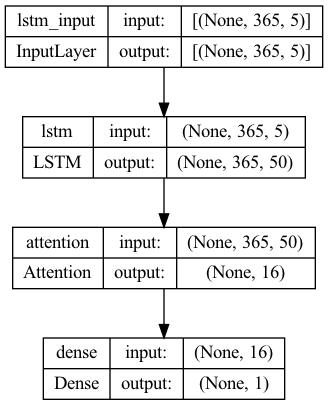

In [10]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Attention(units=16))
model.add(Dense(1))
optimiser = Adam(learning_rate=0.01)
model.compile(loss='mae', optimizer=optimiser, metrics=[metrics.MeanAbsoluteError(), metrics.MeanSquaredError(), metrics.RootMeanSquaredError(), coefficient_of_determination])
print(model.summary())
plot_model(model, to_file='./AttentionWaveletDJIAModel.png', show_shapes=True)

### Train Model

In [11]:
historyOne = model.fit(X_train, y_train, epochs=16, batch_size=32, validation_data=(X_test, y_test), verbose=1)
K.set_value(model.optimizer.learning_rate, 0.001)
historyTwo = model.fit(X_train, y_train, epochs=12, batch_size=32, validation_data=(X_test, y_test), verbose=1)
K.set_value(model.optimizer.learning_rate, 0.0001)
historyThree = model.fit(X_train, y_train, epochs=8, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/16


2022-08-17 16:34:10.590711: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


138/138 [==============================] - ETA: 0s - loss: 0.0336 - mean_absolute_error: 0.0336 - mean_squared_error: 0.0104 - root_mean_squared_error: 0.1021 - coefficient_of_determination: 0.8220

2022-08-17 16:34:25.181371: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


138/138 [==============================] - 17s 103ms/step - loss: 0.0336 - mean_absolute_error: 0.0336 - mean_squared_error: 0.0104 - root_mean_squared_error: 0.1021 - coefficient_of_determination: 0.8220 - val_loss: 0.0165 - val_mean_absolute_error: 0.0165 - val_mean_squared_error: 3.6076e-04 - val_root_mean_squared_error: 0.0190 - val_coefficient_of_determination: -0.2205
Epoch 2/16
138/138 [==============================] - 13s 94ms/step - loss: 0.0118 - mean_absolute_error: 0.0118 - mean_squared_error: 2.9660e-04 - root_mean_squared_error: 0.0172 - coefficient_of_determination: 0.9938 - val_loss: 0.0251 - val_mean_absolute_error: 0.0251 - val_mean_squared_error: 7.0210e-04 - val_root_mean_squared_error: 0.0265 - val_coefficient_of_determination: -1.1470
Epoch 3/16
138/138 [==============================] - 13s 96ms/step - loss: 0.0137 - mean_absolute_error: 0.0137 - mean_squared_error: 4.0278e-04 - root_mean_squared_error: 0.0201 - coefficient_of_determination: 0.9912 - val_loss: 0

### Predict on Test Data

In [12]:
y_hat = model.predict(X_test)

1/4 [======>.......................] - ETA: 1s

2022-08-17 16:43:54.474515: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2400 num_cores: 16 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


4/4 [==============================] - 1s 39ms/step


### Unscale Data

In [13]:
# Undo normalisation
y_test = (y_test * anotherScaler.data_range_[0]) + anotherScaler.data_min_[0]
y_hat = (y_hat * anotherScaler.data_range_[0]) + anotherScaler.data_min_[0]
# Undo standardisation
y_test = (y_test * scaler.scale_[0]) + scaler.mean_[0]
y_hat = (y_hat * scaler.scale_[0]) + scaler.mean_[0]

### Plot Prediction

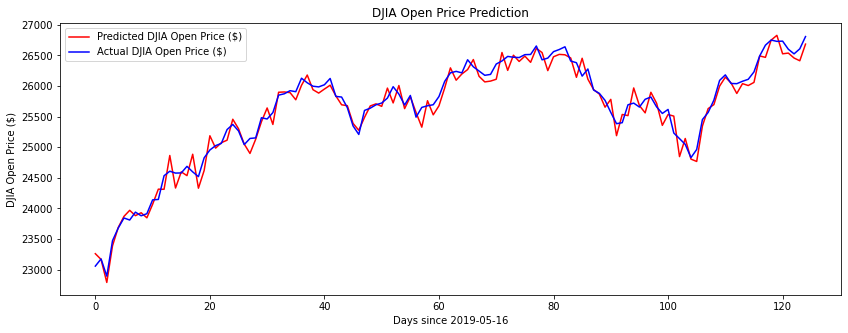

In [14]:
plt.figure(figsize=(14, 5))
plt.plot(y_hat, color='red', label="Predicted DJIA Open Price ($)")
plt.plot(y_test, color='blue', label="Actual DJIA Open Price ($)")
plt.title('DJIA Open Price Prediction')
# plt.xticks(np.arange(dates.shape[0]), dates)
xLabel = "Days since " + splitDate
plt.xlabel(xLabel)
plt.ylabel('DJIA Open Price ($)')
plt.legend()
plt.show()

### Performance Metrics

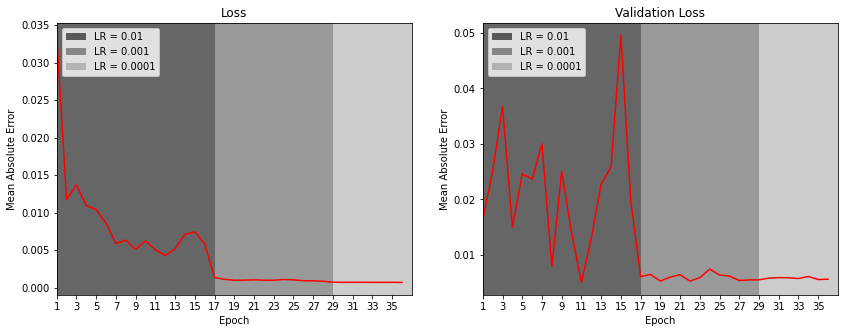

In [15]:
totalLoss = np.concatenate([historyOne.history['loss'], historyTwo.history['loss'], historyThree.history['loss']])
totaValLoss = np.concatenate([historyOne.history['val_loss'], historyTwo.history['val_loss'], historyThree.history['val_loss']])

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(totalLoss, color='red')
plt.axvspan(0, 16, facecolor='black', alpha=0.6, label="LR = 0.01")
plt.axvspan(16, 16+12, facecolor='black', alpha=0.4, label="LR = 0.001")
plt.axvspan(16+12, 16+12+8, facecolor='black', alpha=0.2, label="LR = 0.0001")
plt.xlim(0, 16+12+8)
plt.xticks([2*i for i in range(int((16+12+8)/2))], [(2*j)+1 for j in range(int((16+12+8)/2))])
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(totaValLoss, color='red')
plt.axvspan(0, 16, facecolor='black', alpha=0.6, label="LR = 0.01")
plt.axvspan(16, 16+12, facecolor='black', alpha=0.4, label="LR = 0.001")
plt.axvspan(16+12, 16+12+8, facecolor='black', alpha=0.2, label="LR = 0.0001")
plt.xlim(0, 16+12+8)
plt.xticks([2*i for i in range(int((16+12+8)/2))], [(2*j)+1 for j in range(int((16+12+8)/2))])
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.title("Validation Loss")
plt.legend()

plt.show()

In [16]:
mae = historyThree.history['mean_absolute_error']
mse = historyThree.history['mean_squared_error']
rmse = historyThree.history['root_mean_squared_error']
r2 = historyThree.history['coefficient_of_determination']

print('Mean Absolute Error (MAE): ' + str(mae[-1]))
print('Mean Squared Error (MSE): ' + str(mse[-1]))
print('Root Mean Squared Error (RMSE): ' + str(rmse[-1]))
print('Coefficient of Determination (R2): ' + str(r2[-1]))

Mean Absolute Error (MAE): 0.0007161210523918271
Mean Squared Error (MSE): 2.82263340523059e-06
Root Mean Squared Error (RMSE): 0.0016800694866105914
Coefficient of Determination (R2): 0.9999410510063171


In [17]:
valmae = historyThree.history['val_mean_absolute_error']
valmse = historyThree.history['val_mean_squared_error']
valrmse = historyThree.history['val_root_mean_squared_error']
valr2 = historyThree.history['val_coefficient_of_determination']

print('Validation Mean Absolute Error (MAE): ' + str(valmae[-1]))
print('Validation Mean Squared Error (MSE): ' + str(valmse[-1]))
print('Validation Root Mean Squared Error (RMSE): ' + str(valrmse[-1]))
print('Validation Coefficient of Determination (R2): ' + str(valr2[-1]))

Validation Mean Absolute Error (MAE): 0.005627542268484831
Validation Mean Squared Error (MSE): 4.7036581236170605e-05
Validation Root Mean Squared Error (RMSE): 0.006858321838080883
Validation Coefficient of Determination (R2): 0.8696346879005432


### Trading Strategy

In [18]:
initialBalance = 1000000
actionThreshold = 0.01
sentimentInfluence = 0.005
betProportion = 1

# Random strategy
controlBalance = initialBalance
controlOwnedShares = 0
controlBet = controlBalance / betProportion
controlBuyOrders = 0
controlSellOrders = 0

# Trading the price predictions
balance = initialBalance
ownedShares = 0
bet = balance / betProportion
buyOrders = 0
sellOrders = 0

def Buy(price, bet, balance, ownedShares):
    if (balance > 0):
            numShares = 0
            if (balance >= bet):
                numShares = bet / price
                balance -= bet
                ownedShares += numShares
            else:
                numShares = balance / price
                balance = 0
                ownedShares += numShares
            # print("BUY - " + str(numShares) + " shares at $" + str(price))
            bet = (balance + (ownedShares * price)) / betProportion
    return bet, balance, ownedShares

def Sell(price, bet, balance, ownedShares):
    if (ownedShares > 0):
        numShares = bet / price
        if (ownedShares >= numShares):
            balance += bet
            ownedShares -= numShares
            # print("SELL - " + str(numShares) + " shares at $" + str(price))
        else:
            value = ownedShares * price
            balance += value
            ownedShares = 0
            # print("SELL - " + str(ownedShares) + " shares at $" + str(price))
        bet = (balance + (ownedShares * price)) / betProportion
    return bet, balance, ownedShares

# Random trading strategy
for i in range(len(y_hat)-1):
    if (randint(0, 1) == 0): # ! Buy
        controlBet, controlBalance, controlOwnedShares = Buy(y_test[i], controlBet, controlBalance, controlOwnedShares)
    else: # ! Sell
        controlBet, controlBalance, controlOwnedShares = Sell(y_test[i], controlBet, controlBalance, controlOwnedShares)

# Trading strategy based on price prediction
for i in range(len(y_hat)-1):
    
    currentPrice = y_test[i]
    predictedPrice = y_hat[i+1]
    difference = predictedPrice - currentPrice
    percentageChange = difference / currentPrice

    # No sentiment
    if (abs(percentageChange) < actionThreshold): # ! Hold
        pass
    elif (currentPrice < predictedPrice): # ! Buy
        bet, balance, ownedShares = Buy(y_test[i], bet, balance, ownedShares)
    elif (currentPrice > predictedPrice): # ! Sell
        bet, balance, ownedShares = Sell(y_test[i], bet, balance, ownedShares)

controlTotalShareValue = controlOwnedShares * y_test[-1]
controlFinalBalance = controlBalance + controlTotalShareValue
controlProfit = controlFinalBalance-initialBalance
controlBalancePercentageChange = ((controlFinalBalance-initialBalance)/initialBalance) * 100

totalShareValue = ownedShares * y_test[-1]
finalBalance = balance + totalShareValue
profit = finalBalance-initialBalance
balancePercentageChange = ((finalBalance-initialBalance)/initialBalance) * 100

pricePercentageChange = ((y_test[-1]-y_test[0])/y_test[0]) * 100

print("----------------------------------------------------------------")

print("Trading over " + str(y_hat.shape[0]) + " days")
print("Initial Balance: $" + str(initialBalance))

print("----------------------------------------------------------------")

print("Random Trading Strategy")
# print("Final Balance: $" + str(controlFinalBalance))
print("Profit: $" + str(controlProfit))
print("Balance Percentage Change: " + str(controlBalancePercentageChange) + "%")

print("----------------------------------------------------------------")

print("Buying on day one and holding")
print("Profit: $" + str(initialBalance * (pricePercentageChange/100)))
print("Balance Percentage Change: " + str(pricePercentageChange) + "%")

print("----------------------------------------------------------------")

print("Trading strategy based on price predictions")
# print("Final Balance: $" + str(finalBalance))
print("Profit: $" + str(profit))
print("Balance Percentage Change: " + str(balancePercentageChange) + "%")

print("----------------------------------------------------------------")

----------------------------------------------------------------
Trading over 125 days
Initial Balance: $1000000
----------------------------------------------------------------
Random Trading Strategy
Profit: $15998.462296394864
Balance Percentage Change: 1.5998462296394864%
----------------------------------------------------------------
Buying on day one and holding
Profit: $162509.80005976406
Balance Percentage Change: 16.250980005976405%
----------------------------------------------------------------
Trading strategy based on price predictions
Profit: $242921.25123665063
Balance Percentage Change: 24.292125123665063%
----------------------------------------------------------------
